In [1]:
import torch
import numpy as np
import argparse
import pickle
from collections import defaultdict
from pathlib import Path
from tqdm.auto import tqdm

from data_grn_processing import load_grn_dataset_dgl
from model_grn import GRNGNN, prediction_dgl
from utils import set_config_args, get_comp_g_edge_labels, get_comp_g_path_labels
from utils import src_tgt_khop_in_subgraph, eval_edge_mask_auc, eval_edge_mask_topk_path_hit
from explainer_grn import PaGELink



/home/younggun0816/anaconda3/envs/GRNXAI/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# DGL 그래프에서 feature dimension 가져오기 (feat이 아닌 모든 ndata 속성 사용)
def get_in_dim(mp_g):
    """
    DGL 그래프에서 모든 노드 feature의 총 차원을 계산하는 함수
    """
    node_feats = []
    for key in mp_g.ndata.keys():  # 모든 노드 feature 속성 확인
        feat = mp_g.ndata[key]  # 해당 feature 텐서 가져오기
        if len(feat.shape) == 2:  # (num_nodes, feature_dim) 형태일 경우만 추가
            node_feats.append(feat.shape[1])
    
    if not node_feats:
        raise ValueError("No valid node features found in graph! Check ndata.")

    return sum(node_feats)  # 모든 feature 차원을 더해서 총 in_dim 반환



In [3]:
device_id = 1

In [4]:
if torch.cuda.is_available() and device_id >= 0:
    device = torch.device('cuda', index=device_id)
else:
    device = torch.device('cpu')

print(device)

cuda:1


In [5]:
dataset_dir = "datasets"
dataset_name = "Ecoli1_basic_graph"
valid_ratio = 0.1
test_ratio = 0.2
g, processed_g = load_grn_dataset_dgl(dataset_dir,dataset_name, valid_ratio, test_ratio)
mp_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g = [g.to(device) for g in processed_g]

try:
    in_dim = get_in_dim(mp_g)
except KeyError:
    raise ValueError("Graph does not contain 'feat' in node features. Ensure features are properly assigned.")

hidden_dim_1 = 128
hidden_dim_2 = 64
out_dim = 32
af_val = "F.silu"
dec = "dot_sum"
num_layers = 4
num_epochs = 20
aggr = "sum"
var = "ChebConv"
saved_model_dir = "saved_models"
saved_modal_name = "basic_data_Ecoli1_InSilicoSize100_model"


model = GRNGNN(in_dim, hidden1_channels=128, hidden2_channels=64, out_channels=32, dec='dot_sum', af_val='F.silu', num_layers=4, epoch=20, aggr='sum', var='ChebConv').to(device)
state = torch.load(f'saved_models/basic_data_Ecoli1_InSilicoSize100_model.pth', map_location='cuda')
model.load_state_dict(state) 

pagelink = PaGELink(model, 
                    lr=0.01,
                    alpha=1.0, 
                    beta=1.0, 
                    num_epochs=20,
                    log=True,
                    af_val='F.silu').to(device)


with torch.no_grad():
    pred, pos = prediction_dgl(model, mp_g, af_val, dec)






In [6]:
pos_tensor = torch.tensor(pos, dtype=torch.float32).to(mp_g.device)
mp_g.edata['pred_value'] = pos_tensor  

# 결과 확인
print(mp_g.edata['pred_value'])

tensor([ 1.4012e+03,  3.5524e+03,  5.8931e+03,  1.0206e+04,  1.1939e+04,
         1.4003e+04,  1.6138e+04, -2.0825e+04,  2.0033e+04,  2.1868e+04,
         2.3925e+04,  2.5889e+04,  2.7633e+04,  2.9743e+04,  3.1618e+04,
         3.3554e+04,  3.5700e+04,  3.7687e+04,  3.9645e+04,  4.1575e+04,
         4.6219e+05,  2.2256e+06, -2.0004e+05,  9.2262e+04,  1.3564e+05,
         1.7126e+04,  3.2526e+05,  3.3851e+05,  3.5128e+05,  3.6305e+05,
         3.7648e+05,  3.8949e+05,  4.0144e+05,  4.1438e+05,  4.2561e+05,
        -1.1660e+05,  3.4126e+01, -2.3596e+04,  4.6219e+05,  7.4616e+04,
        -7.6839e+04,  6.3715e+04, -9.3481e+04, -1.5328e+05, -1.5661e+05,
        -1.6670e+05, -1.9366e+05, -1.9691e+05, -2.0040e+05,  1.6491e+05,
         1.5729e+05,  3.0055e+04, -2.2358e+05,  2.7773e+04, -2.3043e+05,
        -2.3362e+05, -2.1347e+05, -1.9317e+05, -2.4374e+05, -1.4684e+05,
         1.0964e+05,  5.1368e+05,  7.8509e+05, -2.7332e+02, -4.8751e+05,
         8.1580e+05,  2.2256e+06, -3.4917e+05, -5.6

In [7]:
import torch

edata_values = mp_g.edata['pred_value']

print(edata_values)
print(min(edata_values))

print("Min:", torch.min(edata_values).item())  # 최소값
print("Max:", torch.max(edata_values).item())  # 최대값
print("Mean:", torch.mean(edata_values).item())  # 평균값
print("Sample values:", edata_values[:10])  # 샘플 출력


tensor([ 1.4012e+03,  3.5524e+03,  5.8931e+03,  1.0206e+04,  1.1939e+04,
         1.4003e+04,  1.6138e+04, -2.0825e+04,  2.0033e+04,  2.1868e+04,
         2.3925e+04,  2.5889e+04,  2.7633e+04,  2.9743e+04,  3.1618e+04,
         3.3554e+04,  3.5700e+04,  3.7687e+04,  3.9645e+04,  4.1575e+04,
         4.6219e+05,  2.2256e+06, -2.0004e+05,  9.2262e+04,  1.3564e+05,
         1.7126e+04,  3.2526e+05,  3.3851e+05,  3.5128e+05,  3.6305e+05,
         3.7648e+05,  3.8949e+05,  4.0144e+05,  4.1438e+05,  4.2561e+05,
        -1.1660e+05,  3.4126e+01, -2.3596e+04,  4.6219e+05,  7.4616e+04,
        -7.6839e+04,  6.3715e+04, -9.3481e+04, -1.5328e+05, -1.5661e+05,
        -1.6670e+05, -1.9366e+05, -1.9691e+05, -2.0040e+05,  1.6491e+05,
         1.5729e+05,  3.0055e+04, -2.2358e+05,  2.7773e+04, -2.3043e+05,
        -2.3362e+05, -2.1347e+05, -1.9317e+05, -2.4374e+05, -1.4684e+05,
         1.0964e+05,  5.1368e+05,  7.8509e+05, -2.7332e+02, -4.8751e+05,
         8.1580e+05,  2.2256e+06, -3.4917e+05, -5.6

In [8]:
import torch

# 1️⃣ 현재 pred_value 값 확인
edata_values = mp_g.edata['pred_value']
print("Before processing:")
print("Min:", torch.min(edata_values).item())
print("Max:", torch.max(edata_values).item())
print("Mean:", torch.mean(edata_values).item())

# 2️⃣ 모든 값을 양수로 만들기 (Shift 변환)
min_strength = torch.min(edata_values)
shifted_strength = edata_values - min_strength  # 최소값을 0으로 이동

# 3️⃣ 모든 값을 0~1 범위로 정규화 (Scaling)
max_shifted = torch.max(shifted_strength)
normalized_strength = shifted_strength / max_shifted  # 0~1 정규화

# 4️⃣ 정규화된 값 적용
mp_g.edata['pred_value'] = normalized_strength

# 5️⃣ 결과 확인
print("After processing:")
print("Min:", torch.min(mp_g.edata['pred_value']).item())  # 0이 나와야 함
print("Max:", torch.max(mp_g.edata['pred_value']).item())  # 1이 나와야 함
print("Mean:", torch.mean(mp_g.edata['pred_value']).item())  # 평균값 확인


Before processing:
Min: -3548931.0
Max: 14756336.0
Mean: 877018.25
After processing:
Min: 0.0
Max: 1.0
Mean: 0.24178554117679596


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

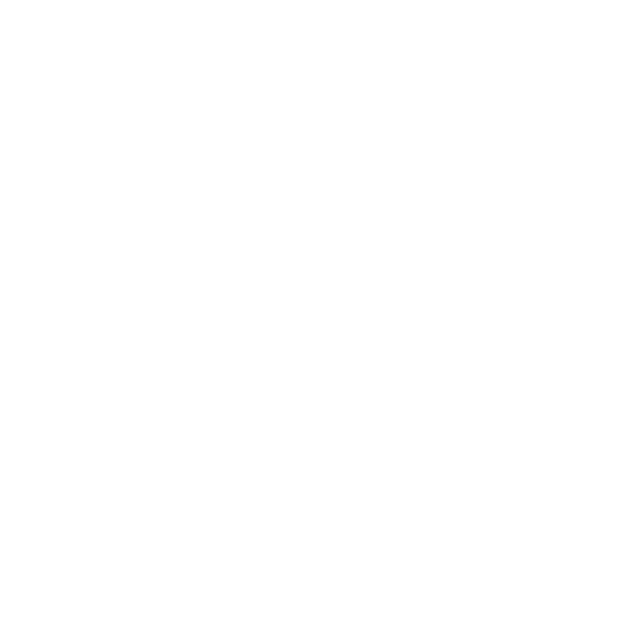

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
# 래프 시각화
plt.figure(figsize=(6, 6))
nx.draw(nx_g, with_labels=True, node_color='lightblue', edge_color='gray', node_size=30, font_size=10)
plt.show()


In [13]:
'''
Path finding utils
'''
def get_neg_path_score_func(g, weight, exclude_node=[]):
    '''
    Compute the negative path score for the shortest path algorithm.
    
    Parameters
    ----------
    g : dgl graph

    weight: string
       The edge weights stored in g.edata

    exclude_node : iterable
        Degree of these nodes will be set to 0 when computing the path score, so they will likely be included.

    Returns
    ----------
    neg_path_score_func: callable function
       Takes in two node ids and return the edge weight. 
    '''
    log_eweights = g.edata[weight].log().squeeze(-1).tolist()
    if isinstance(log_eweights, float):  # 단일 값일 경우
        log_eweights = [log_eweights]  # 리스트로 변환

    
    log_in_degrees = g.in_degrees().log()
    log_in_degrees[exclude_node] = 0
    log_in_degrees = log_in_degrees.tolist()
    u, v = g.edges()

    neg_path_score_map = {edge : log_in_degrees[edge[1]] - log_eweights[i] for i, edge in enumerate(zip(u.tolist(), v.tolist()))}

    def neg_path_score_func(u, v):
        return neg_path_score_map[(u, v)]
    return neg_path_score_func

In [14]:
import collections
import networkx as nx
from utils import k_shortest_paths_with_max_length

# 1️⃣ PyG 그래프를 NetworkX 그래프로 변환 (경로 검색을 위해)
nx_g = nx.Graph()
src, tgt = mp_g.edges()

# Edge weight 설정 (get_neg_path_score_func을 적용)
neg_path_score_func = get_neg_path_score_func(mp_g, 'pred_value', exclude_node=[])

for u, v in zip(src.tolist(), tgt.tolist()):
    weight = neg_path_score_func(u, v)  # 새로운 함수 사용
    nx_g.add_edge(u, v, weight=weight)  # 음수 경로 가중치 설정

# 2️⃣ 노드 차수 확인 (허브 노드 제거를 위한 기준)
node_degrees = dict(nx_g.degree())
max_degree_threshold = 100  # 허브 노드 필터링 (100 이상 연결된 노드는 제외)

# 3️⃣ path_label 저장용 defaultdict 생성
path_label = collections.defaultdict(list)

# 4️⃣ 모든 엣지에 대해 최적의 경로 찾기
l_max = 3  # 최대 경로 길이
P_max = 5  # 상위 P개 경로 선택

for src_nid, tgt_nid in zip(src.tolist(), tgt.tolist()):
    print(f"src, tgt : ({src_nid} , {tgt_nid})")
    if src_nid in nx_g and tgt_nid in nx_g:
        # 다익스트라 기반 최단 경로 검색 (새로운 weight 적용)
        paths = k_shortest_paths_with_max_length(mp_g, 
                                                 src_nid, 
                                                 tgt_nid, 
                                                 weight=neg_path_score_func, 
                                                 k=P_max)
        
        print(f"paths:{paths}")

        # 경로 필터링: 길이 제한 및 허브 노드 제거
        filtered_paths = [
            path for path in paths if len(path) <= l_max and all(node_degrees.get(n, 0) < max_degree_threshold for n in path)
        ]
        print(f"filtered_paths:{filtered_paths}")

        # path_label에 저장
        path_label[(src_nid, tgt_nid)] = [tuple(zip(path[:-1], path[1:])) for path in filtered_paths]

# 결과 확인
print("Sample path_label:", list(path_label.items())[:3])  # 일부만 출력


src, tgt : (4 , 1)
paths:[[4, 1]]
filtered_paths:[[4, 1]]
src, tgt : (4 , 2)
paths:[[4, 2]]
filtered_paths:[[4, 2]]
src, tgt : (4 , 3)
paths:[[4, 3]]
filtered_paths:[[4, 3]]
src, tgt : (4 , 5)
paths:[[4, 5]]
filtered_paths:[[4, 5]]
src, tgt : (4 , 6)
paths:[[4, 6], [4, 9, 36, 24, 6]]
filtered_paths:[[4, 6]]
src, tgt : (4 , 7)
paths:[[4, 7], [4, 9, 36, 7]]
filtered_paths:[[4, 7]]
src, tgt : (4 , 8)
paths:[[4, 8]]
filtered_paths:[[4, 8]]
src, tgt : (4 , 9)
paths:[[4, 9]]
filtered_paths:[[4, 9]]
src, tgt : (4 , 10)
paths:[[4, 10]]
filtered_paths:[[4, 10]]
src, tgt : (4 , 11)
paths:[[4, 11]]
filtered_paths:[[4, 11]]
src, tgt : (4 , 12)
paths:[[4, 12]]
filtered_paths:[[4, 12]]
src, tgt : (4 , 13)
paths:[[4, 13], [4, 14, 13]]
filtered_paths:[[4, 13], [4, 14, 13]]
src, tgt : (4 , 14)
paths:[[4, 14]]
filtered_paths:[[4, 14]]
src, tgt : (4 , 15)
paths:[[4, 15]]
filtered_paths:[[4, 15]]
src, tgt : (4 , 16)
paths:[[4, 16]]
filtered_paths:[[4, 16]]
src, tgt : (4 , 17)
paths:[[4, 17]]
filtered_path

In [49]:
print("Sample path_label:", list(path_label.items())[:1]) 

Sample path_label: [((4, 1), [((4, 1),)])]


In [27]:
dataset_dir = "datasets"
dataset_name = "Ecoli1_basic_graph"
valid_ratio = 0.1
test_ratio = 0.2
g, processed_g = load_grn_dataset_dgl(dataset_dir,dataset_name, valid_ratio, test_ratio)
mp_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g = [g.to(device) for g in processed_g]


In [30]:
print(g)
print(mp_g)



Graph(num_nodes=100, num_edges=173,
      ndata_schemes={'wildtype': Scheme(shape=(1,), dtype=torch.float32), 'id': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'KD': Scheme(shape=(1,), dtype=torch.float32), 'KO': Scheme(shape=(1,), dtype=torch.float32)})
Graph(num_nodes=100, num_edges=173,
      ndata_schemes={'wildtype': Scheme(shape=(1,), dtype=torch.float32), 'id': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'KD': Scheme(shape=(1,), dtype=torch.float32), 'KO': Scheme(shape=(1,), dtype=torch.float32)})


In [15]:
from data_processing import load_dataset
valid_ratio = 0.1
test_ratio = 0.2
dataset_name = "aug_citation"
dataset_dir = 'datasets'

g, processed_g, pred_pair_to_edge_labels, pred_pair_to_path_labels = load_dataset(dataset_dir,
                                                                                  dataset_name,
                                                                                  valid_ratio,
                                                                                  test_ratio)


Type of pred_pair_to_edge_labels: <class 'dict'>
Type of pred_pair_to_path_labels: <class 'collections.defaultdict'>
Length of pred_pair_to_edge_labels: 4501
Length of pred_pair_to_path_labels: 4501
Sample keys in pred_pair_to_edge_labels: [(('author', 1), ('paper', np.int64(2217)))]
Sample keys in pred_pair_to_path_labels: [(('author', 1), ('paper', np.int64(2217)))]


In [ ]:


print("Type of pred_pair_to_edge_labels:", type(pred_pair_to_edge_labels))
print("Type of pred_pair_to_path_labels:", type(pred_pair_to_path_labels))
print("Length of pred_pair_to_edge_labels:", len(pred_pair_to_edge_labels))
print("Length of pred_pair_to_path_labels:", len(pred_pair_to_path_labels))


print("Sample keys in pred_pair_to_edge_labels:", list(pred_pair_to_edge_labels.keys())[:1])
print("Sample keys in pred_pair_to_path_labels:", list(pred_pair_to_path_labels.keys())[:1])

In [20]:
print("Sample keys in pred_pair_to_edge_labels:", list(pred_pair_to_edge_labels.keys())[:1])
print("Sample keys in pred_pair_to_path_labels:", list(pred_pair_to_path_labels.keys())[:1])

Sample keys in pred_pair_to_edge_labels: [(('author', 1), ('paper', np.int64(2217)))]
Sample keys in pred_pair_to_path_labels: [(('author', 1), ('paper', np.int64(2217)))]


In [21]:
key = (('author', 1), ('paper', np.int64(2217)))  # 해당 키를 변수에 저장
value = pred_pair_to_edge_labels[key]  # 딕셔너리에서 키로 값 조회
print(value)  # 값 출력


defaultdict(<class 'set'>, {('author', 'writes', 'paper'): (tensor([1, 1]), tensor([529, 212])), ('paper', 'in', 'fos'): (tensor([529, 212]), tensor([812, 812])), ('fos', 'of', 'paper'): (tensor([812]), tensor([2217]))})


In [25]:
import torch
print(set(zip(torch.tensor([529, 212]), torch.tensor([812, 812]))))


{(tensor(212), tensor(812)), (tensor(529), tensor(812))}


In [22]:
key = (('author', 1), ('paper', np.int64(2217)))  # 해당 키를 변수에 저장
value = pred_pair_to_path_labels[key]  # 딕셔너리에서 키로 값 조회
print(value)  # 값 출력


[[(('author', 'writes', 'paper'), 1, 529), (('paper', 'in', 'fos'), 529, 812), (('fos', 'of', 'paper'), 812, 2217)], [(('author', 'writes', 'paper'), 1, 212), (('paper', 'in', 'fos'), 212, 812), (('fos', 'of', 'paper'), 812, 2217)]]


In [13]:


with torch.no_grad():
    pred, pos = prediction_dgl(model, mp_g, af_val, dec)

print(mp_g)

print(len(pred))
print(type(pred))
print(pos)


Graph(num_nodes=100, num_edges=173,
      ndata_schemes={'wildtype': Scheme(shape=(1,), dtype=torch.float32), 'id': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'KD': Scheme(shape=(1,), dtype=torch.float32), 'KO': Scheme(shape=(1,), dtype=torch.float32)})
173
<class 'numpy.ndarray'>
[ 1.40120630e+03  3.55243848e+03  5.89308301e+03  1.02057373e+04
  1.19388418e+04  1.40031113e+04  1.61383174e+04 -2.08246914e+04
  2.00330586e+04  2.18680156e+04  2.39251426e+04  2.58888828e+04
  2.76326660e+04  2.97433340e+04  3.16176836e+04  3.35535117e+04
  3.57002969e+04  3.76867383e+04  3.96445039e+04  4.15748906e+04
  4.62188312e+05  2.22560450e+06 -2.00040922e+05  9.22621094e+04
  1.35639781e+05  1.71262285e+04  3.25263031e+05  3.38506938e+05
  3.51278406e+05  3.63046062e+05  3.76481812e+05  3.89492875e+05
  4.01435000e+05  4.14375844e+05  4.25605312e+05 -1.16599078e+05
  3.41255188e+01 -2.35964102e+04  4.62188312e+05  7.46156172e+04
 -7.68391250e+04  6.37151211e+04 -9.34809766e+04 

In [ ]:

test_src_nids, test_tgt_nids = test_pos_g.edges()
comp_graphs = defaultdict(list)
comp_g_labels = defaultdict(list)
num_hops = 2
i = 4
# Get the k-hop subgraph
src_nid, tgt_nid = test_src_nids[i], test_tgt_nids[i]
comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_feat_nids, comp_g_eids = src_tgt_khop_in_subgraph( src_nid,
                                                                                     tgt_nid,
                                                                                            mp_g,
                                                                                            num_hops)
with torch.no_grad():
    pred, pos = prediction_dgl(model, mp_g, af_val, dec)


# Extract edges from the graph
edge_index = torch.stack(comp_g.edges(), dim=0).cpu().numpy()
src_tgt_pair = np.array([comp_g_src_nid.cpu().numpy(), comp_g_tgt_nid.cpu().numpy()]).reshape(2, 1)

# Check if the prediction contains this specific edge
mask = np.all(edge_index == src_tgt_pair, axis=0)

if mask.sum() > 0 and pred[mask][0]:  # src_nid -> tgt_nid에 대한 예측 값이 1인지 확인
    src_tgt = (int(src_nid), int(tgt_nid))
    comp_graphs[src_tgt] = [comp_g_src_nid, comp_g_tgt_nid, comp_g, comp_g_feat_nids]
